In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, subprocess
import desimodel.focalplane
import desimodel.io
from astropy.table import Table
from desitarget.targetmask import desi_mask, obsconditions
%matplotlib inline

In [2]:
workdir = os.path.join(os.environ['SCRATCH'], 'desi', 'test', 'fiberassign')
os.makedirs(workdir, exist_ok=True)
os.chdir(workdir)
outdir = os.path.join(workdir, 'output')
os.makedirs(outdir, exist_ok=True)

In [3]:
!pwd

/global/cscratch1/sd/forero/desi/test/fiberassign


In [4]:
ntiles = 2
tiles = Table()
tile_radius = desimodel.focalplane.get_tile_radius_deg()
tiles['TILEID'] = np.arange(ntiles, dtype='i4') +5
tiles['RA'] = 2 + np.arange(ntiles)*0.5*tile_radius
tiles['DEC'] = np.ones(ntiles)*30
tiles['PASS'] = np.zeros(ntiles, dtype='i2')
tiles['OBSCONDITIONS'] = np.ones(ntiles, dtype='i4') * obsconditions.DARK
tiles['IN_DESI'] = np.ones(ntiles, dtype='i2')
tiles['PROGRAM'] = np.full(ntiles, 'DARK', dtype='S6')
tiles.write('tiles.fits', format='fits', overwrite=True)

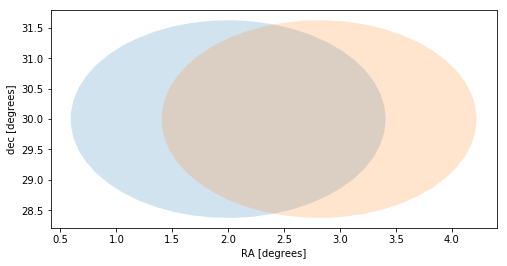

In [5]:
def plot_sky_circle(ra, dec, radius=0.1, alpha=0.2):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = ra + np.cos(np.radians(dec))*radius*np.cos(theta)
    yy = dec + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha)

def plot_circle(ra, dec, radius=0.1, alpha=0.2):
    plot_sky_circle(ra, dec, radius=radius, alpha=alpha)

def plot_circles(ra, dec, radius=0.1, alpha=0.2):
    for i in range(len(ra)):
        plot_circle(ra[i], dec[i], radius=radius, alpha=alpha)
    plt.xlabel('RA [degrees]')
    plt.ylabel('dec [degrees]')

plt.figure(figsize=(8,4))
plot_circles(tiles['RA'], tiles['DEC'], radius=desimodel.focalplane.get_tile_radius_deg())

(30.1, 30.200000000000003)

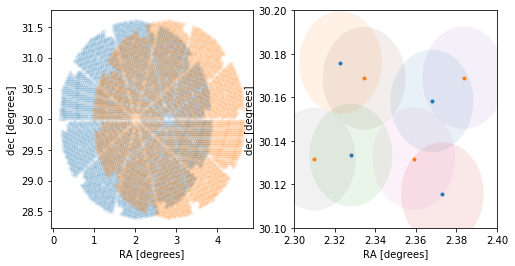

In [6]:
def plot_positioners(tilera, tiledec, boundary=None, alpha=0.1, circles=False):
    fiberpos = desimodel.io.load_fiberpos()
    ra, dec = desimodel.focalplane.xy2radec(tilera, tiledec, fiberpos['X'], fiberpos['Y'])
    if boundary is not None:
        ii = (ra<boundary['max_ra'])&(ra>boundary['min_ra'])&(dec<boundary['max_dec'])&(dec>boundary['min_dec'])
        ra = ra[ii]
        dec = dec[ii]
        
    plt.plot(ra, dec, '.', alpha=alpha)
    if circles == True:
        fiber_radius = desimodel.io.load_desiparams()['positioners']['radius_max']
        fiber_radius *= desimodel.focalplane.get_tile_radius_deg()/desimodel.focalplane.get_tile_radius_mm()
        plot_circles(ra, dec, radius=fiber_radius, alpha=0.1)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
for i in range(len(tiles)):
    plot_positioners(tiles['RA'][i], tiles['DEC'][i])

plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')

min_ra = 2.30
max_ra = min_ra+0.1
min_dec = 30.1
max_dec = min_dec+0.1
boundary = {'min_ra':min_ra, 'min_dec':min_dec, 'max_ra':max_ra, 'max_dec':max_dec}
plt.subplot(1,2,2)
for i in range(len(tiles)):
    plot_positioners(tiles['RA'][i], tiles['DEC'][i], boundary=boundary, alpha=1.0, circles=True)

plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')
plt.xlim([boundary['min_ra'], boundary['max_ra']])
plt.ylim([boundary['min_dec'], boundary['max_dec']])

In [7]:
def generate_targets_in_tile(tile_ra, tile_dec, n_targets_per_fiber=1, boundary=None):
    # compute fiber radius
    fiber_radius = desimodel.io.load_desiparams()['positioners']['radius_max']
    fiber_radius *= desimodel.focalplane.get_tile_radius_deg()/desimodel.focalplane.get_tile_radius_mm()
    
    # compute the positions of all positioners
    fiberpos = desimodel.io.load_fiberpos()
    ra, dec = desimodel.focalplane.xy2radec(tile_ra, tile_dec, fiberpos['X'], fiberpos['Y'])
    
    # select only positioners within the input boundary 
    ii = (ra<boundary['max_ra'])&(ra>boundary['min_ra'])&(dec<boundary['max_dec'])&(dec>boundary['min_dec'])
    ra = ra[ii]
    dec = dec[ii]
    print(len(ra), ra, fiber_radius)
    
    # generate targets within the fiber radius. We generate n_targets_per_fiber
    n_fibers = len(ra)
    targets_ra = np.ones(n_fibers * n_targets_per_fiber)
    targets_dec = np.ones(n_fibers * n_targets_per_fiber)
    theta = -np.ones(n_fibers * n_targets_per_fiber)*np.pi/4.0
    for i in range(n_fibers):
        targets_ra[i*n_targets_per_fiber:(i+1)*n_targets_per_fiber] = ra[i] + 0.1*fiber_radius * np.cos(theta[i*n_targets_per_fiber:(i+1)*n_targets_per_fiber])
        targets_dec[i*n_targets_per_fiber:(i+1)*n_targets_per_fiber] = dec[i] + 0.1*fiber_radius * np.sin(theta[i*n_targets_per_fiber:(i+1)*n_targets_per_fiber])
    return targets_ra, targets_dec

def generate_targets_in_tiles(tiles, n_targets_per_fiber=1, boundary=None):
    n_tiles = len(tiles)
    r = np.empty((0))
    d = np.empty((0))
    print(r)
    for i in range(n_tiles):
        _r, _d = generate_targets_in_tile(tiles['RA'][i], tiles['DEC'][i], n_targets_per_fiber=n_targets_per_fiber, boundary=boundary)
        r = np.append(r, _r)
        d = np.append(d, _d)
        
    n = len(r) 
    while True:
        targetids = np.random.randint(0, 2**62-1, n)
        if len(set(targetids)) == n:
            break
        #- Create targets table
    targets = Table()
    targets['TARGETID'] = targetids
    targets['RA'] = r.copy()
    targets['DEC'] = d.copy()
    targets['DESI_TARGET'] = np.zeros(n, dtype='i8')
    targets['BGS_TARGET'] = np.zeros(n, dtype='i8')
    targets['MWS_TARGET'] = np.zeros(n, dtype='i8')
    targets['SUBPRIORITY'] = np.random.uniform(0, 1, n)
    targets['BRICKNAME'] = np.full(n, '000p0000')    #- required !?!
    targets['BRICKID'] = np.full(n, 0)    #- required !?!
    targets['BRICK_OBJID'] = np.arange(n)
    
    #- dummy values for fluxes
    for filt in ['G', 'R', 'Z']:
        targets['FIBERFLUX_'+filt] = np.zeros(n, dtype='f4')
        targets['FIBERFLUX_IVAR_'+filt] = np.ones(n, dtype='f4')
    return targets


targets = generate_targets_in_tiles(tiles, n_targets_per_fiber=1, boundary=boundary)

targets['PRIORITY'] = 1000
targets['SUBPRIORITY'] = np.random.uniform(0, 1, len(targets))
targets['DESI_TARGET'] = desi_mask.ELG
targets['OBSCONDITIONS'] = np.ones(len(targets), dtype='i4') * obsconditions.DARK
targets['NUMOBS_MORE'] = np.ones(len(targets), dtype='i8')
targets.meta['EXTNAME'] = 'MTL'

targets.write('mtl.fits', overwrite=True)

sky = targets.copy()
sky['RA'] = sky['RA'] 
sky['DEC'] = sky['DEC'] + 1.0
sky['TARGETID'] = targets['TARGETID']//10
sky['DESI_TARGET'] = desi_mask.SKY
sky['NUMOBS_MORE'] = 10
sky['OBSCONDITIONS'] = np.ones(len(sky), dtype='i4') * obsconditions.mask('DARK|GRAY|BRIGHT')
sky.meta['EXTNAME'] = 'SKY'
sky.write('sky.fits', overwrite=True)

[]
4 [2.36793844 2.32285934 2.3280053  2.37310949] 0.023616120809053606
4 [2.38365662 2.3344956  2.35902898 2.30991501] 0.023616120809053606


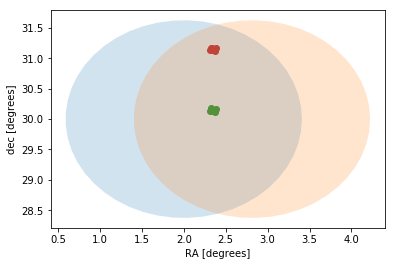

In [8]:
sky_data = Table.read('sky.fits')
targets_data = Table.read('mtl.fits')
tiles_data = Table.read('tiles.fits')
plot_circles(tiles_data['RA'], tiles_data['DEC'], radius=desimodel.focalplane.get_tile_radius_deg())
plt.scatter(targets_data['RA'], targets_data['DEC'])
plt.scatter(sky_data['RA'], sky_data['DEC'])

In [9]:
cmd = 'fiberassign --overwrite --mtl mtl.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())

RUNNING: fiberassign --overwrite --mtl mtl.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/
INFO: Loaded focalplane for time stamp 2020-02-20 21:06:30.362050
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Target file mtl.fits has 8 rows.  Reading in chunks of 1000000
INFO: Read target file mtl.fits:  0.01 seconds (1 calls)
INFO: Target file sky.fits has 8 rows.  Reading in chunks of 1000000
INFO: Read target file sky.fits:  0.00 seconds (1 calls)
INFO: Building target tree:  0.00 seconds (1 calls)
INFO: Computing targets available to all tile / locations:  0.01 seconds (1 calls)
INFO: Computing tile / locations available to all objects:  0.00 seconds (1 calls)
INFO: Assignment constructor project targets:  0.00 seconds (1 calls)
INFO: assign unused science:  considering 5000 locations of positioner type "POS"
INFO: assign unused science:  working on tiles -1 (index 0) to -1 (index 1)
INFO: Assign science targets to unused locations:  0.00 seconds (1 calls)
I